# Preprocessing Module
The primary purpose of this module is to gather, preprocess, split all of the data that will be used for our various models. Below is an outline for the preprocessed datasets that will be needed for the various models:
- **Ensemble Model**: Consists of 4 separate models requiring a total of 4 different preprocessed datasets.
- **Dual Model**: Consists of 2 separate models requiring a total of 2 different preprocessed datasets.
- **Four-Class Model**: Consists of 1 model requiring 1 preprocessed datasets. 

Additionally, this model aims to quantify the bias within the preprocessed datasets, to identify giveaways in the data sets that make it unrealistically easy for the models to identify the right diagnosis based on artifacts or patterns in the images coming from different sources.

# Import Libraries

In [2]:
# Basic Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

#Set directory
current_directory_path = r"C:\\Users\\atr8e/OneDrive/Documents/MSDS/2024_Spring/DS_6050/Project/Milestone_3/"
os.chdir(current_directory_path)

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Image Libraries
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from PIL import Image
import lime
from lime import lime_image
import cv2  # Import cv2 for image processing
from skimage.transform import resize
import pickle

# Functions
Below you can find three for conducting the preprocessing:
- **set_limiting_factor()**: To assure balanced data in the preprocessed dataset, you can use this function to feed in the directory paths to the datasets to return the number of images in the shortest dataset. This allows you to select the number of images you want to use from each dataset without having to pull in the all of images.
- **preprocess_images()**:
  - Takes the path to the dataset of interest, the label you want for the dataset, and the limiting factor for the number of images to take.
  - Preprocesses the images by converting to grayscale, resizing, and normalizing the colors.
  - Produces a sample of newly preprocessed images.
  - Splits them into train, validation, and test at an 80%/10%/10% split.
  - Returns the images and their respective labels.
- **preprocessing_images_bulk()**
  - Takes a list of paths to multiple datasets, labels for each of them, and the limiting factor.
  - Preprocesses each dataset using preprocess_images().
  - Combines the split datasets.
  - Returns the split datasets.

In [3]:
def set_limiting_factor(dataset_paths):
    '''Pass a list of directory paths to return the length of the shortest one'''
    limiting_factor = min(len(os.listdir(dataset)) for dataset in dataset_paths)
    print(f'Limiting Factor of Datasets: {limiting_factor}')
    return limiting_factor

In [4]:
# Function to preprocess the images in a given directory
def preprocess_images(image_dir, label, limiting_factor=100):
    images = []
    labels = []
    count = 0
    
    for filename in os.listdir(image_dir):
        if count >= limiting_factor:
            break  # Exit the loop if we've processed enough images
        
        if filename.endswith(".jpeg") or filename.endswith(".png"):
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            if image.mode != "L":
                image = image.convert("L")    # Convert grayscale to RGB
            image = image.resize((256, 256))  # Resize images to 256x256 pixels
            
            # Normalize pixel values to [0, 1] by min-max scaling
            image_array = np.array(image)
            min_val = np.min(image_array)
            max_val = np.max(image_array)
            image_array_normalized = (image_array - min_val) / (max_val - min_val + 1e-9)  # Add small value to avoid division by zero
            
            images.append(image)
            labels.append(label)
            count += 1
            if (count % round((limiting_factor/4)) == 0) | (count == limiting_factor):
                print(f'Processed: {count}/{limiting_factor} images for {image_dir[81:]}')
    
    # Display sample images from each class
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(3, 5, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"{image_dir[81:]}")
        plt.axis("off")
    plt.show()
    
    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    # Split the data into train/validation/test split of 80/10/10
    train_images, test_images, \
    train_labels, test_labels \
    = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)
    
    validation_images, test_images, \
    validation_labels, test_labels \
    = train_test_split(test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

In [5]:
# Function to preprocess images from multiple directories with respective labels
def preprocess_images_bulk(image_dir_list, label_list, limiting_factor=100):
    train_images = []
    validation_images = []
    test_images = []
    train_labels = []
    validation_labels = []
    test_labels = []
    
    for image_dir, label in zip(image_dir_list, label_list):
        train_images_i, validation_images_i, test_images_i, \
        train_labels_i, validation_labels_i, test_labels_i \
        = preprocess_images(image_dir, label, limiting_factor=limiting_factor)
        
        # Append images from current directory to the list
        train_images.extend(train_images_i) 
        validation_images.extend(validation_images_i)
        test_images.extend(test_images_i)
        
        # Append labels from current directory to the list
        train_labels.extend(train_labels_i)
        validation_labels.extend(validation_labels_i)
        test_labels.extend(test_labels_i)
        
    return train_images, validation_images, test_images, \
           train_labels, validation_labels, test_labels

# Datasets

In [6]:
# Set paths to the datasets
dataset_dir = r"C:\\Users\\atr8e/OneDrive/Documents/MSDS/2024_Spring/DS_6050/Project/Milestone_3/"

# Healthy Lung XRays
pneumonia_neg_dir = os.path.join(dataset_dir, "Pneumonia_Healthy")
covid_neg_dir = os.path.join(dataset_dir, "Covid_Healthy")
tuberculosis_neg_dir = os.path.join(dataset_dir, "Tuberculosis_Healthy")

# Unhealthy Lung XRays
pneumonia_pos_dir = os.path.join(dataset_dir, "Pneumonia_Unhealthy")
covid_pos_dir = os.path.join(dataset_dir, "Covid_Unhealthy")
tuberculosis_pos_dir = os.path.join(dataset_dir, "Tuberculosis_Unhealthy")

# Ensemble Model
Consists of 4 separate models requiring 4 different preprocessed datasets:
#### Main Model
- **Goal**: Determine if a test image is healthy or unhealthy.
- **Dataset**: Preprocessed dataset consisting of six parts, i.e. the healthy and unhealthy data from each of the three datasets.
- **Labels**: Healthy_Pn: 0, Healthy_Cv: 0, Healthy_Tb: 0, Pneumonia: 1, Covid: 1, Tuberculosis: 1

#### Pneumonia Model
- **Goal**: Determine if an unhealthy test image shows signs of Pneumonia.
- **Dataset**: Preprocessed dataset consisting of two parts, i.e. the healthy and unhealthy Pneumonia data.
- **Labels**: Healthy: 0, Pneumonia: 1

#### Covid Model
- **Goal**: Determine if an unhealthy test image shows signs of Covid.
- **Dataset**: Preprocessed dataset consisting of two parts, i.e. the healthy and unhealthy Covid data.
- **Labels**: Healthy: 0, Covid: 1

#### Tuberculosis Model
- **Goal**: Determine if a unhealthy test image shows signs of Tuberculosis.
- **Dataset**: Preprocessed dataset consisting of two parts, i.e. the healthy and unhealthy Tuberculosis data.
- **Labels**: Healthy: 0, Tuberculosis: 1

## List the paths, set the labels, and set the limiting factor for each respective dataset of interest

In [8]:
# Main Model Dataset
ensemble_main_paths = [pneumonia_neg_dir, covid_neg_dir, tuberculosis_neg_dir,
                       pneumonia_pos_dir, covid_pos_dir, tuberculosis_pos_dir]
ensemble_main_labels = [0,0,0,1,1,1]
ensemble_main_lf = set_limiting_factor(ensemble_main_paths)
ensemble_main_inputs = ensemble_main_paths, ensemble_main_labels, ensemble_main_lf

# Pneumonia Model Dataset
ensemble_pn_paths = [pneumonia_neg_dir, pneumonia_pos_dir]
ensemble_pn_labels = [0,1]
ensemble_pn_lf = set_limiting_factor(ensemble_pn_paths)
ensemble_pn_inputs = ensemble_pn_paths, ensemble_pn_labels, ensemble_pn_lf

# Covid Model Dataset
ensemble_cv_paths = [covid_neg_dir, covid_pos_dir]
ensemble_cv_labels = [0,1]
ensemble_cv_lf = set_limiting_factor(ensemble_cv_paths)
ensemble_cv_inputs = ensemble_cv_paths, ensemble_cv_labels, ensemble_cv_lf

# Tuberculosis Model Dataset
ensemble_tb_paths = [tuberculosis_neg_dir, tuberculosis_pos_dir]
ensemble_tb_labels = [0,1]
ensemble_tb_lf = set_limiting_factor(ensemble_tb_paths)
ensemble_tb_inputs = ensemble_tb_paths, ensemble_tb_labels, ensemble_tb_lf

Limiting Factor of Datasets: 701
Limiting Factor of Datasets: 1342
Limiting Factor of Datasets: 1301
Limiting Factor of Datasets: 701


## Process, Split, and Save the Ensemble Main Model Datasets

Processed: 175/701 images for Pneumonia_Healthy
Processed: 350/701 images for Pneumonia_Healthy
Processed: 525/701 images for Pneumonia_Healthy
Processed: 700/701 images for Pneumonia_Healthy
Processed: 701/701 images for Pneumonia_Healthy


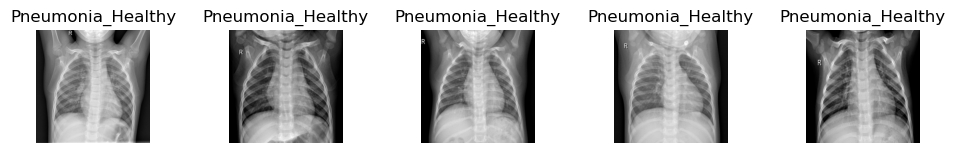

Processed: 175/701 images for Covid_Healthy
Processed: 350/701 images for Covid_Healthy
Processed: 525/701 images for Covid_Healthy
Processed: 700/701 images for Covid_Healthy
Processed: 701/701 images for Covid_Healthy


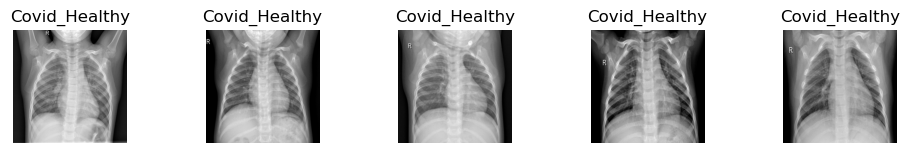

Processed: 175/701 images for Tuberculosis_Healthy
Processed: 350/701 images for Tuberculosis_Healthy
Processed: 525/701 images for Tuberculosis_Healthy
Processed: 700/701 images for Tuberculosis_Healthy
Processed: 701/701 images for Tuberculosis_Healthy


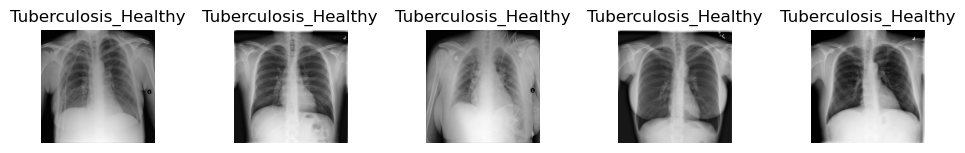

Processed: 175/701 images for Pneumonia_Unhealthy
Processed: 350/701 images for Pneumonia_Unhealthy
Processed: 525/701 images for Pneumonia_Unhealthy
Processed: 700/701 images for Pneumonia_Unhealthy
Processed: 701/701 images for Pneumonia_Unhealthy


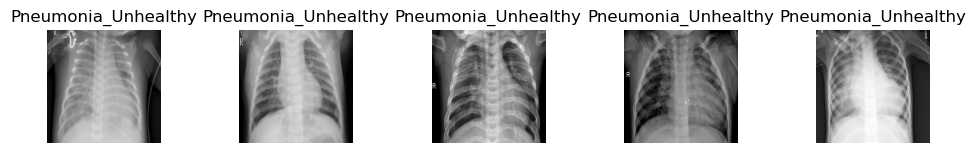

Processed: 175/701 images for Covid_Unhealthy
Processed: 350/701 images for Covid_Unhealthy
Processed: 525/701 images for Covid_Unhealthy
Processed: 700/701 images for Covid_Unhealthy
Processed: 701/701 images for Covid_Unhealthy


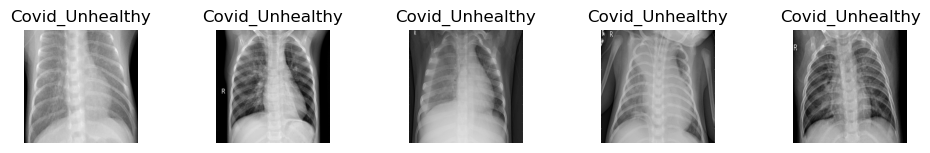

Processed: 175/701 images for Tuberculosis_Unhealthy
Processed: 350/701 images for Tuberculosis_Unhealthy
Processed: 525/701 images for Tuberculosis_Unhealthy
Processed: 700/701 images for Tuberculosis_Unhealthy


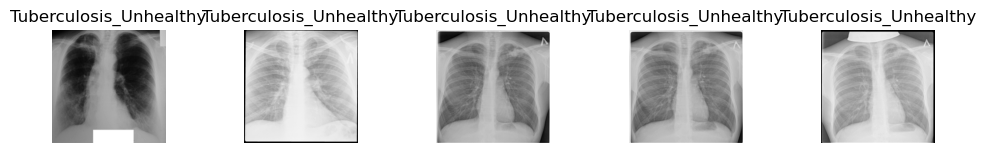

In [7]:
# Process and Split
en_main_train_images, en_main_val_images, en_main_test_images, \
en_main_train_labels, en_main_val_labels, en_main_test_labels = preprocess_images_bulk(*ensemble_main_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_main_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_main_train_images, en_main_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_main_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_main_val_images, en_main_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_main_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_main_test_images, en_main_test_labels), file)

## Process and Split the Ensemble Pneumonia Model

Processed: 336/1342 images for Pneumonia_Healthy
Processed: 672/1342 images for Pneumonia_Healthy
Processed: 1008/1342 images for Pneumonia_Healthy


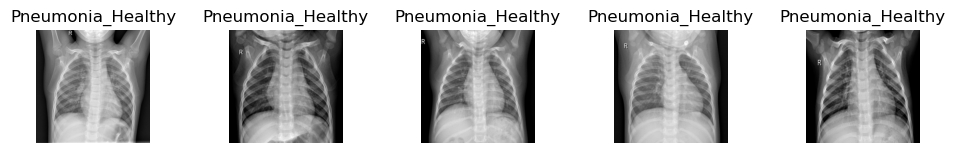

Processed: 336/1342 images for Pneumonia_Unhealthy
Processed: 672/1342 images for Pneumonia_Unhealthy
Processed: 1008/1342 images for Pneumonia_Unhealthy
Processed: 1342/1342 images for Pneumonia_Unhealthy


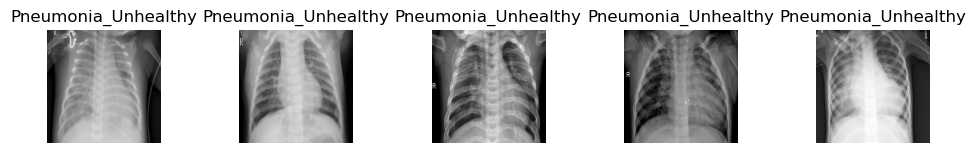

In [8]:
# Process and Split
en_pn_train_images, en_pn_val_images, en_pn_test_images, \
en_pn_train_labels, en_pn_val_labels, en_pn_test_labels = preprocess_images_bulk(*ensemble_pn_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_pn_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_pn_train_images, en_pn_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_pn_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_pn_val_images, en_pn_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_pn_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_pn_test_images, en_pn_test_labels), file)

## Process and Split the Ensemble Covid Model

Processed: 325/1301 images for Covid_Healthy
Processed: 650/1301 images for Covid_Healthy
Processed: 975/1301 images for Covid_Healthy
Processed: 1300/1301 images for Covid_Healthy
Processed: 1301/1301 images for Covid_Healthy


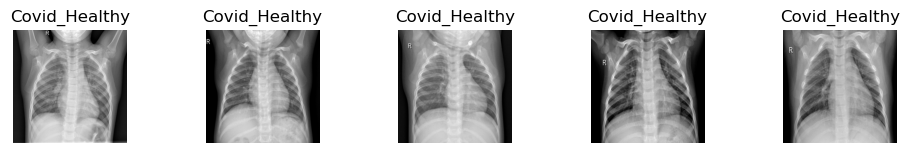

Processed: 325/1301 images for Covid_Unhealthy
Processed: 650/1301 images for Covid_Unhealthy
Processed: 975/1301 images for Covid_Unhealthy
Processed: 1300/1301 images for Covid_Unhealthy
Processed: 1301/1301 images for Covid_Unhealthy


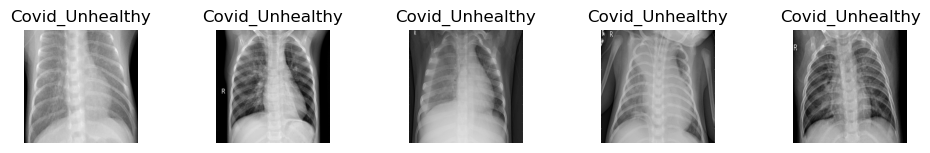

In [9]:
# Process and Split
en_cv_train_images, en_cv_val_images, en_cv_test_images, \
en_cv_train_labels, en_cv_val_labels, en_cv_test_labels = preprocess_images_bulk(*ensemble_cv_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_cv_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_cv_train_images, en_cv_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_cv_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_cv_val_images, en_cv_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_cv_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_cv_test_images, en_cv_test_labels), file)

## Process and Split the Ensemble Tuberculosis Model

Processed: 175/701 images for Tuberculosis_Healthy
Processed: 350/701 images for Tuberculosis_Healthy
Processed: 525/701 images for Tuberculosis_Healthy
Processed: 700/701 images for Tuberculosis_Healthy
Processed: 701/701 images for Tuberculosis_Healthy


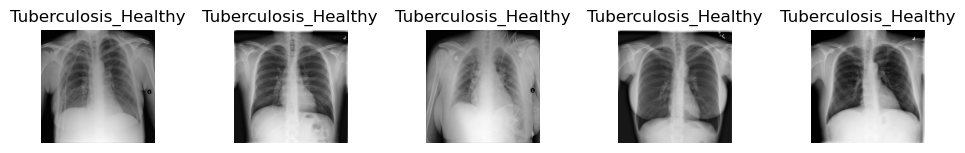

Processed: 175/701 images for Tuberculosis_Unhealthy
Processed: 350/701 images for Tuberculosis_Unhealthy
Processed: 525/701 images for Tuberculosis_Unhealthy
Processed: 700/701 images for Tuberculosis_Unhealthy


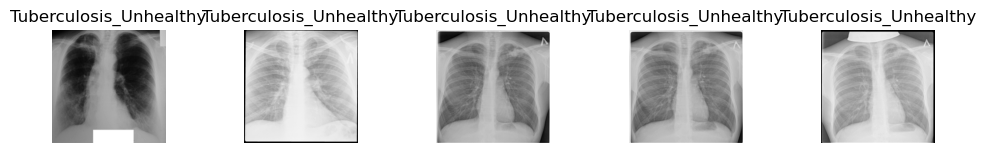

In [10]:
# Process and Split
en_tb_train_images, en_tb_val_images, en_tb_test_images, \
en_tb_train_labels, en_tb_val_labels, en_tb_test_labels = preprocess_images_bulk(*ensemble_tb_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_tb_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_tb_train_images, en_tb_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_tb_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_tb_val_images, en_tb_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Ensemble_Model/en_tb_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((en_tb_test_images, en_tb_test_labels), file)

# Dual Model
Consists of 2 separate models requiring 2 different preprocessed datasets:
#### Main Model (same as Ensemble Main Model)
- **Goal**: Determine if a test image is healthy or unhealthy.
- **Dataset**: Preprocessed dataset consisting of six parts, i.e. the healthy and unhealthy data from each of the three datasets.
- **Labels**: Healthy_Pn: 0, Healthy_Cv: 0, Healthy_Tb: 0, Pneumonia: 1, Covid: 1, Tuberculosis: 1

#### Unhealthy Model
- **Goal**: Determine what disease an unhealthy test image expressed most.
- **Dataset**: Preprocessed dataset consisting of three parts, i.e. the unhealthy Pneumonia, Covid, and Tuberculosis data.
- **Labels**: Pneumonia: 0, Covid: 1, Tuberculosis: 2

## Process and Split the Dual Main Model

In [11]:
# Main Model Dataset (set to be the same as the Ensemble Main Model)
dual_main_train_images, dual_main_val_images, dual_main_test_images, \
dual_main_train_labels, dual_main_val_labels, dual_main_test_labels = \
en_main_train_images, en_main_val_images, en_main_test_images, \
en_main_train_labels, en_main_val_labels, en_main_test_labels

# Save Training Data
file_path = 'Models_and_Datasets/Dual_Model/dual_main_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_main_train_images, dual_main_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Dual_Model/dual_main_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_main_val_images, dual_main_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Dual_Model/dual_main_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_main_test_images, dual_main_test_labels), file)

## Process and Split the Dual Unhealthy Model

In [12]:
# Unhealthy Model Dataset
dual_uh_paths = [pneumonia_pos_dir, covid_pos_dir, tuberculosis_pos_dir]
dual_uh_labels = [0,1,2]
dual_uh_lf = set_limiting_factor(dual_uh_paths)
dual_uh_inputs = dual_uh_paths, dual_uh_labels, dual_uh_lf

Limiting Factor of Datasets: 701


Processed: 175/701 images for Pneumonia_Unhealthy
Processed: 350/701 images for Pneumonia_Unhealthy
Processed: 525/701 images for Pneumonia_Unhealthy
Processed: 700/701 images for Pneumonia_Unhealthy
Processed: 701/701 images for Pneumonia_Unhealthy


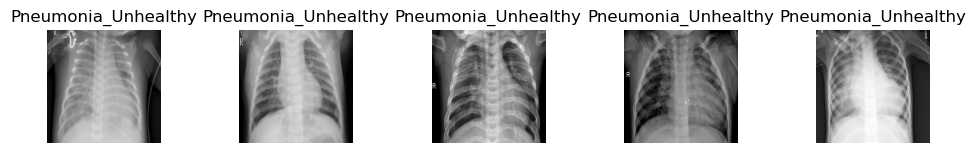

Processed: 175/701 images for Covid_Unhealthy
Processed: 350/701 images for Covid_Unhealthy
Processed: 525/701 images for Covid_Unhealthy
Processed: 700/701 images for Covid_Unhealthy
Processed: 701/701 images for Covid_Unhealthy


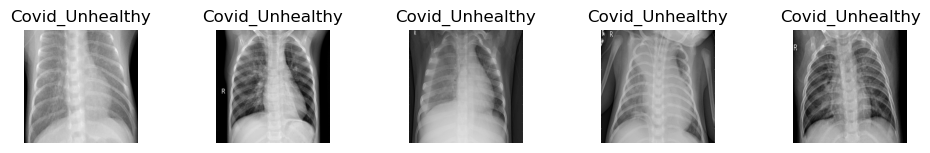

Processed: 175/701 images for Tuberculosis_Unhealthy
Processed: 350/701 images for Tuberculosis_Unhealthy
Processed: 525/701 images for Tuberculosis_Unhealthy
Processed: 700/701 images for Tuberculosis_Unhealthy


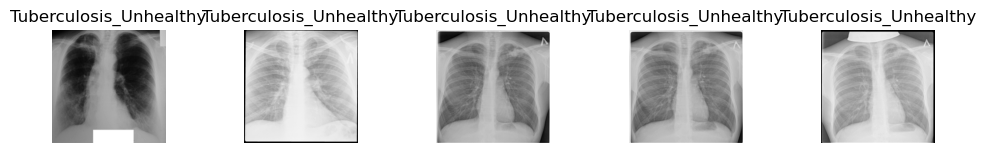

In [13]:
# Process and Split
dual_uh_train_images, dual_uh_val_images, dual_uh_test_images, \
dual_uh_train_labels, dual_uh_val_labels, dual_uh_test_labels = preprocess_images_bulk(*dual_uh_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Dual_Model/dual_uh_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_uh_train_images, dual_uh_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Dual_Model/dual_uh_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_uh_val_images, dual_uh_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Dual_Model/dual_uh_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((dual_uh_test_images, dual_uh_test_labels), file)

# Four-Class Model
Consists of 1 model requiring 1 preprocessed dataset:
#### Four-Class Model
- **Goal**: Determine if a test image expresses a lung that is healthy, has Pneumonia, has Covid, or has Tuberculosis.
- **Dataset**: Preprocessed dataset consisting of six parts, i.e. the healthy and unhealthy data from each of the three datasets.
- **Labels**: Healthy_Pn: 0, Healthy_Cv: 0, Healthy_Tb: 0, Pneumonia: 1, Covid: 2, Tuberculosis: 3

In [14]:
# Four-Class Model Dataset
four_class_paths = [pneumonia_neg_dir, covid_neg_dir, tuberculosis_neg_dir,
                       pneumonia_pos_dir, covid_pos_dir, tuberculosis_pos_dir]
four_class_labels = [0,0,0,1,2,3]
four_class_lf = set_limiting_factor(four_class_paths)
four_class_inputs = four_class_paths, four_class_labels, four_class_lf

Limiting Factor of Datasets: 701


Processed: 175/701 images for Pneumonia_Healthy
Processed: 350/701 images for Pneumonia_Healthy
Processed: 525/701 images for Pneumonia_Healthy
Processed: 700/701 images for Pneumonia_Healthy
Processed: 701/701 images for Pneumonia_Healthy


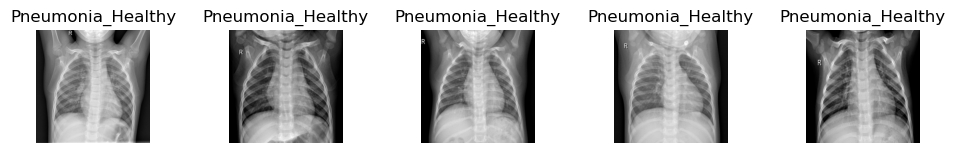

Processed: 175/701 images for Covid_Healthy
Processed: 350/701 images for Covid_Healthy
Processed: 525/701 images for Covid_Healthy
Processed: 700/701 images for Covid_Healthy
Processed: 701/701 images for Covid_Healthy


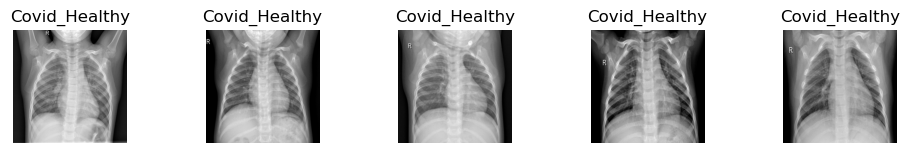

Processed: 175/701 images for Tuberculosis_Healthy
Processed: 350/701 images for Tuberculosis_Healthy
Processed: 525/701 images for Tuberculosis_Healthy
Processed: 700/701 images for Tuberculosis_Healthy
Processed: 701/701 images for Tuberculosis_Healthy


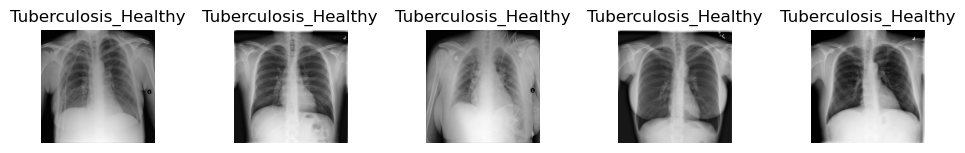

Processed: 175/701 images for Pneumonia_Unhealthy
Processed: 350/701 images for Pneumonia_Unhealthy
Processed: 525/701 images for Pneumonia_Unhealthy
Processed: 700/701 images for Pneumonia_Unhealthy
Processed: 701/701 images for Pneumonia_Unhealthy


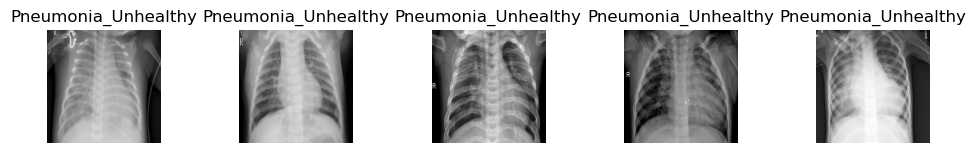

Processed: 175/701 images for Covid_Unhealthy
Processed: 350/701 images for Covid_Unhealthy
Processed: 525/701 images for Covid_Unhealthy
Processed: 700/701 images for Covid_Unhealthy
Processed: 701/701 images for Covid_Unhealthy


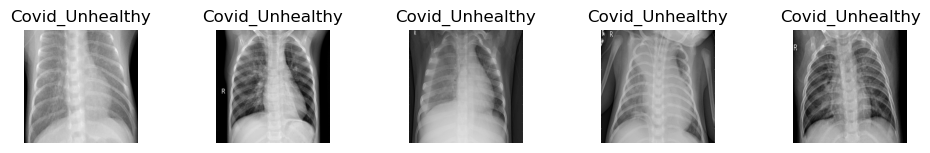

Processed: 175/701 images for Tuberculosis_Unhealthy
Processed: 350/701 images for Tuberculosis_Unhealthy
Processed: 525/701 images for Tuberculosis_Unhealthy
Processed: 700/701 images for Tuberculosis_Unhealthy


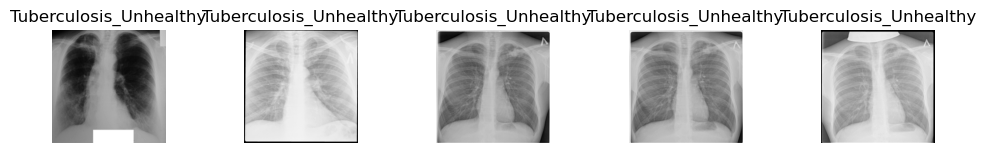

In [15]:
# Process and Split
four_class_train_images, four_class_val_images, four_class_test_images, \
four_class_train_labels, four_class_val_labels, four_class_test_labels = preprocess_images_bulk(*four_class_inputs)

# Save Training Data
file_path = 'Models_and_Datasets/Four_Class_Model/four_class_train.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((four_class_train_images, four_class_train_labels), file)
    
# Save Validation Data
file_path = 'Models_and_Datasets/Four_Class_Model/four_class_val.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((four_class_val_images, four_class_val_labels), file)
    
# Save Testing Data
file_path = 'Models_and_Datasets/Four_Class_Model/four_class_test.pkl'
with open(file_path, 'wb') as file:
    pickle.dump((four_class_test_images, four_class_test_labels), file)

In [16]:
## Load the dataset from the file
#with open(file_path, 'rb') as file:
#    test_images, test_labels = pickle.load(file)
#
#test_images